<a href="https://colab.research.google.com/github/rebeccadimatteo/FitDiary_FIA/blob/main/Classificazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione

## Ottenimento del dataset

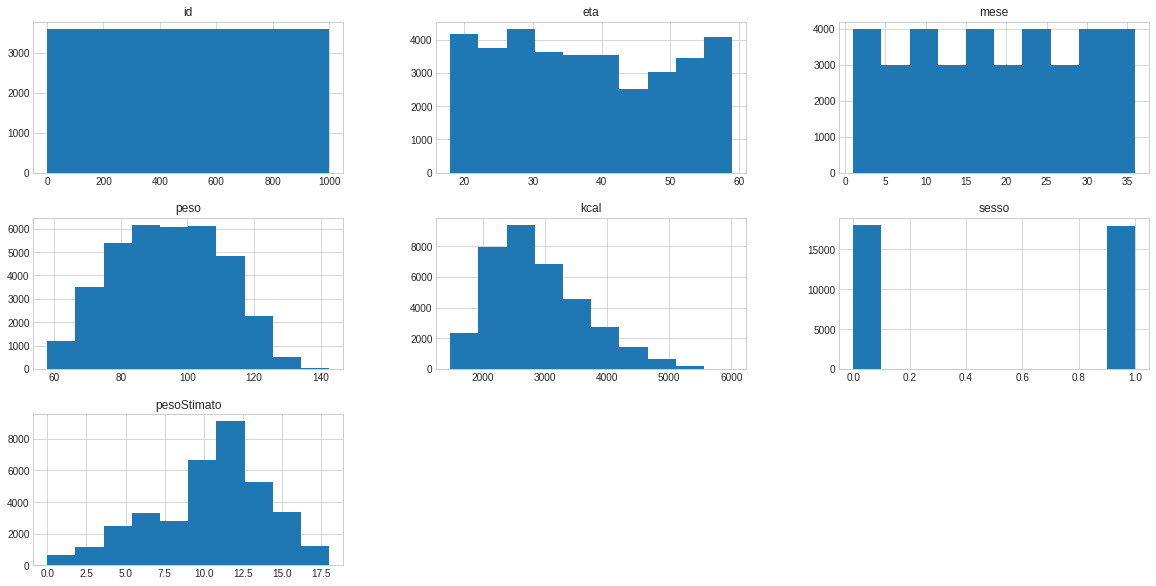

,id,eta,mese,peso,kcal,sesso,pesoStimato
0,1,31,1,97.00000,1965,0,4
1,1,31,2,99.06005,2047,0,5
2,1,31,3,100.93987,2127,0,4
3,1,31,4,103.08139,2365,0,9
4,1,31,5,103.97695,2900,0,12


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from six.moves import urllib

from matplotlib import style

style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20,10)



DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/FitDiary_FIA/master/datasetClassificazione.csv"

def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df=df[["id", "eta", "mese", "peso", "kcal", "sesso", "pesoStimato"]]
df.hist()
plt.show()
df.head(5)

## 1) DataCleaning

## 1.1) Descrizione del dataset

In [2]:
df.describe()

,id,eta,mese,peso,kcal,sesso,pesoStimato
count,36000.000,36000.00000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,500.500,37.73400,18.500000,94.244248,2882.834750,0.499000,10.286444
std,288.679,12.03899,10.388439,15.965455,746.024417,0.500006,3.722119
min,1.000,18.00000,1.000000,57.922405,1477.000000,0.000000,0.000000
25%,250.750,28.00000,9.750000,81.807890,2319.750000,0.000000,8.000000
50%,500.500,37.00000,18.500000,94.261995,2750.000000,0.000000,11.000000
75%,750.250,48.00000,27.250000,106.820873,3335.000000,1.000000,13.000000
max,1000.000,59.00000,36.000000,142.536450,6012.000000,1.000000,18.000000


## 1.2) Verifica valori null nel dataset

In [3]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

In [4]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.3) Correlazione delle features

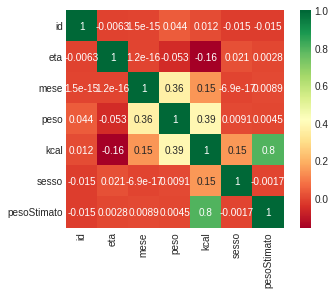

In [5]:
#dipendenze tra variabili
import seaborn as sb
sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) definizione classe metrics

In [6]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,precision,recall,accuracy,mcc,model):
    self.precision=precision
    self.recall=recall
    self.accuracy=accuracy
    self.mcc=mcc
    self.model=model
  
  #ToString
  def __str__(self):
    return f'Metrics [precision= {self.precision} recall= {self.recall} accuracy= {self.accuracy} mcc= {self.mcc}'

### 2.2)Definizione class MetricsResultContainer

In [7]:
import numpy as np
class MetricsResultContainer:
  meanPrecision = []
  meanRecall = []
  meanAccuracy = []
  meanMcc =[]
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean,balance):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanPrecision = []
    self.meanRecall = []
    self.meanAccuracy = []
    self.meanMcc =[]
    self.balance=balance
  
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanPrecision.append(m.precision)
      self.meanRecall.append(m.recall)
      self.meanAccuracy.append(m.accuracy)
      self.meanMcc.append(m.mcc)
    print("meanPrecision=",np.mean(self.meanPrecision))    
    print("meanRecall=",np.mean(self.meanRecall))    
    print("meanAccuracy=",np.mean(self.meanAccuracy))
    print("meanMcc=",np.mean(self.meanMcc))

### 2.3) Definizione funzione generateModel

In [8]:
import copy
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

def generateModel(alg, scaler, model, select,balance):
  #array di metriche (precision, recall, accuracy, mcc)
  metrics1 = []
  #generazione n_split test/trainig sets
  
  for train_index, test_index in alg.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train,y_train=balance(X_train,y_train)
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    #applicazione feature scaling su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)
    
    #training dell'algoritmo sui training set
    model.fit(X_train_z,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = model.predict(X_test_z)
    modelCopy = copy.copy(model)
    #calcolo metriche predizion
    metrics1.append(Metrics1(metrics.precision_score(y_test,y_pred,
                                           average='micro'),
                            metrics.recall_score(y_test,y_pred,
                                           average='micro'),
                            metrics.accuracy_score(y_test,y_pred),
                            metrics.matthews_corrcoef(y_test,y_pred) ,
                            modelCopy))
    
  #array medie degli errori kf
  meanPrecision = []
  meanRecall = []
  meanAccuracy = []
  meanMcc =[]

  #calcolo singole medie degli errori kf
  for m in metrics1:
    meanPrecision.append(m.precision)
    meanRecall.append(m.recall)
    meanAccuracy.append(m.accuracy)
    meanMcc.append(m.mcc)
    

  print("meanPrecision=",np.mean(meanPrecision))    
  print("meanRecall=",np.mean(meanRecall))    
  print("meanAccuracy=",np.mean(meanAccuracy))
  print("meanMcc=",np.mean(meanMcc))

  return metrics1
#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns='pesoStimato')
y=df.pesoStimato
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#Kf con k gruppi
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni della ram del coso
rkfRF = RepeatedKFold(n_splits=2, n_repeats=8, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_classif, k=4)
#risultati: array di array di metriche
metricsResults = []

###2.4) Data Balancing

In [9]:
from imblearn.under_sampling import RandomUnderSampler

#funzione per bilanciare i dati uso di undersample
def bilanciamentoDatiUnderSampling(X_train,y_train):
 undersample = RandomUnderSampler(sampling_strategy='majority')
 X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
 return X_train_under, y_train_under

In [10]:
from imblearn.over_sampling import RandomOverSampler

#funzione per bilanciare i dati uso di overfitting
def bilanciamentoDatiOverSampling(X_train,y_train):
 oversample = RandomOverSampler(random_state=42)
 X_train_over, y_train_over= oversample.fit_resample(X_train, y_train)
 return X_train_over, y_train_over

## 3) Model testing

### 3.1) NaiveBayes

#### 3.1.1) Gaussian Naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB

print("Gaussian Naive Bayes - ZScore Normalization - KF-Under Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nGaussian Naive Bayes - ZScore Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nGaussian Naive Bayes - MinMax Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nGaussian Naive Bayes - MinMax Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nGaussian Naive Bayes - RobustScaler Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  GaussianNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nGaussian Naive Bayes - RobustScaler Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), GaussianNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nGaussian Naive Bayes - ZScore Normalization - KF-Over Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nGaussian Naive Bayes - ZScore Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nGaussian Naive Bayes - MinMax Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nGaussian Naive Bayes - MinMax Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nGaussian Naive Bayes - RobustScaler Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  GaussianNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nGaussian Naive Bayes - RobustScaler Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Gaussian Naive Bayes","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), GaussianNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

Gaussian Naive Bayes - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.20802777777777778
meanRecall= 0.20802777777777778
meanAccuracy= 0.20802777777777778
meanMcc= 0.13334229618608853

Gaussian Naive Bayes - ZScore Normalization - RKF- Under Sampler
meanPrecision= 0.20786666666666664
meanRecall= 0.20786666666666664
meanAccuracy= 0.20786666666666664
meanMcc= 0.13351549364862195

Gaussian Naive Bayes - MinMax Normalization - KF- Under Sampler
meanPrecision= 0.20691666666666667
meanRecall= 0.20691666666666667
meanAccuracy= 0.20691666666666667
meanMcc= 0.1319371436817319

Gaussian Naive Bayes - MinMax Normalization - RKF- Under Sampler
meanPrecision= 0.207625
meanRecall= 0.207625
meanAccuracy= 0.207625
meanMcc= 0.13324174712716036

Gaussian Naive Bayes - RobustScaler Normalization - KF- Under Sampler
meanPrecision= 0.20713888888888887
meanRecall= 0.20713888888888887
meanAccuracy= 0.20713888888888887
meanMcc= 0.13226065349654995

Gaussian Naive Bayes - RobustScaler Normalization - 

### 3.1.2 Bernoulli Naive Bayes

In [12]:
from sklearn.naive_bayes import BernoulliNB

print("Bernoulli Naive Bayes - ZScore Normalization - KF-Under Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nBernoulli Naive Bayes - ZScore Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nBernoulli Naive Bayes - MinMax Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nBernoulli Naive Bayes - MinMax Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nBernoulli Naive Bayes - RobustScaler Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  BernoulliNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nBernoulli Naive Bayes - RobustScaler Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), BernoulliNB(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nBernoulli Naive Bayes - ZScore Normalization - KF-Over Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nBernoulli Naive Bayes - ZScore Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nBernoulli Naive Bayes - MinMax Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nBernoulli Naive Bayes - MinMax Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nBernoulli Naive Bayes - RobustScaler Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  BernoulliNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nBernoulli Naive Bayes - RobustScaler Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Bernoulli Naive Bayes","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), BernoulliNB(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

Bernoulli Naive Bayes - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.1491111111111111
meanRecall= 0.1491111111111111
meanAccuracy= 0.1491111111111111
meanMcc= 0.0623923113766865

Bernoulli Naive Bayes - ZScore Normalization - RKF- Under Sampler
meanPrecision= 0.1477111111111111
meanRecall= 0.1477111111111111
meanAccuracy= 0.1477111111111111
meanMcc= 0.05867797173964775

Bernoulli Naive Bayes - MinMax Normalization - KF- Under Sampler
meanPrecision= 0.12811111111111112
meanRecall= 0.12811111111111112
meanAccuracy= 0.12811111111111112
meanMcc= -0.0005205397749428935

Bernoulli Naive Bayes - MinMax Normalization - RKF- Under Sampler
meanPrecision= 0.12614999999999998
meanRecall= 0.12614999999999998
meanAccuracy= 0.12614999999999998
meanMcc= -0.0008842321826684884

Bernoulli Naive Bayes - RobustScaler Normalization - KF- Under Sampler
meanPrecision= 0.16036111111111112
meanRecall= 0.16036111111111112
meanAccuracy= 0.16036111111111112
meanMcc= 0.07543375894904153

Bernoulli Naiv

## 3.2 Decision tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

print("Decision Tree Classifier - ZScore Normalization - KF-Under Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nDecision Tree Classifier - ZScore Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nDecision Tree Classifier - MinMax Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nDecision Tree Classifier - MinMax Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nDecision Tree Classifier - RobustScaler Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nDecision Tree Classifier - RobustScaler Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), DecisionTreeClassifier(), select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nDecision Tree Classifier - ZScore Normalization - KF-Over Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nDecision Tree Classifier - ZScore Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nDecision Tree Classifier - MinMax Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nDecision Tree Classifier - MinMax Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nDecision Tree Classifier - RobustScaler Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nDecision Tree Classifier - RobustScaler Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Decision Tree Classifier","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), DecisionTreeClassifier(), select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

Decision Tree Classifier - ZScore Normalization - KF-Under Sampler
meanPrecision= 0.2604722222222222
meanRecall= 0.2604722222222222
meanAccuracy= 0.2604722222222222
meanMcc= 0.2013098200997091

Decision Tree Classifier - ZScore Normalization - RKF- Under Sampler
meanPrecision= 0.24335555555555555
meanRecall= 0.24335555555555555
meanAccuracy= 0.24335555555555555
meanMcc= 0.1834325647062233

Decision Tree Classifier - MinMax Normalization - KF- Under Sampler
meanPrecision= 0.24883333333333332
meanRecall= 0.24883333333333332
meanAccuracy= 0.24883333333333332
meanMcc= 0.18862892617389967

Decision Tree Classifier - MinMax Normalization - RKF- Under Sampler
meanPrecision= 0.24758333333333335
meanRecall= 0.24758333333333335
meanAccuracy= 0.24758333333333335
meanMcc= 0.18800367757384912

Decision Tree Classifier - RobustScaler Normalization - KF- Under Sampler
meanPrecision= 0.2628055555555555
meanRecall= 0.2628055555555555
meanAccuracy= 0.2628055555555555
meanMcc= 0.20400833998523943

Decisi

## 3.3) VotingClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

voting=VotingClassifier(estimators=[('dt',DecisionTreeClassifier(max_depth=4)),
                                    ('knn',KNeighborsClassifier(n_neighbors=7)),
                                    ('scv',SVC(kernel="rbf",probability=True))],
                        voting="hard")

print("Voting Classifier - ZScore Normalization - KF-Under Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  voting, select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nVoting Classifier - ZScore Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  voting, select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nVoting Classifier - MinMax Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  voting, select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nVoting Classifier - MinMax Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  voting, select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nVoting Classifier - RobustScaler Normalization - KF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  voting, select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nVoting Classifier - RobustScaler Normalization - RKF- Under Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), voting, select,bilanciamentoDatiUnderSampling),
    "underSampler"
  )
)

print("\nVoting Classifier - ZScore Normalization - KF-Over Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  voting, select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nVoting Classifier - ZScore Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  voting, select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nVoting Classifier - MinMax Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  voting, select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nVoting Classifier - MinMax Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  voting, select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nVoting Classifier - RobustScaler Normalization - KF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  voting, select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)

print("\nVoting Classifier - RobustScaler Normalization - RKF- Over Sampler")
metricsResults.append(
  MetricsResultContainer("Voting Classifier","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), voting, select,bilanciamentoDatiOverSampling),
    "overSampler"
  )
)


Voting Classifier - ZScore Normalization - KF-Under Sampler
